## Reporte Push Notifications- GETM

### Environment settings

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import pandas_gbq
import gspread
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import altair as alt
# Import authenticator and gspread to manage g-sheets
from oauth2client.service_account import ServiceAccountCredentials
from google.oauth2 import service_account
from google.cloud import bigquery
from googleapiclient.discovery import build

**Credentials**

In [4]:
# Create sheets and drive scopes to authenticate
scopes = ['https://www.googleapis.com/auth/spreadsheets',
        'https://www.googleapis.com/auth/drive',
        'https://www.googleapis.com/auth/analytics.readonly']

# Read google credentials
credentials = '../APIs/gepp-538-db.json'
# Read credentials
gs_credentials = ServiceAccountCredentials.from_json_keyfile_name(credentials, scopes)
gc = gspread.authorize(gs_credentials)
# connect to query credentials
credentials = service_account.Credentials.from_service_account_file(credentials)
project_id = 'gepp-538'
client = bigquery.Client(credentials=credentials,project=project_id)

**Conections to data sources**

In [5]:
# Access GETM push notifications worksheet by url
sheet_id = '1hruQi6_vTNfsE3iO0KSqnl8HJNBz-wnZhGjPE1x2rXs' 
workbook = gc.open_by_key(sheet_id)
# Access data by worksheet sheet number
getm_push = workbook.worksheet('Push Notifications')
# Save data to table
getm_values_push = getm_push.get_all_values()
# Save accessed data from google sheets to dataframes
getm_push = pd.DataFrame(getm_values_push[1:],columns=getm_values_push[0])
# drop irrelevant columns
getm_push = getm_push.drop(['Año','Mes','Proyecto','Publicación','Caracteres','Espacios','Tipo','ID'],
    axis=1)

In [7]:
# google analytics
getm_view_id = '219175238'
mpe_view_id = '109327488'
api = '../APIs/gepp-538-db.json'
scopes = ['https://www.googleapis.com/auth/spreadsheets',
        'https://www.googleapis.com/auth/drive',
        'https://www.googleapis.com/auth/analytics.readonly']
# connect to google sheets
gs_credentials = ServiceAccountCredentials.from_json_keyfile_name(api, scopes)
gc = gspread.authorize(gs_credentials)
# connect to big query
bq_credentials = service_account.Credentials.from_service_account_file(api)
project_id = 'gepp-538'
client = bigquery.Client(credentials=bq_credentials,project=project_id)
# connect to analytics service
service = build('analyticsreporting','v4',credentials=gs_credentials)

In [9]:
# google analytics connection
def create_df(response):
    
    #create two empty lists that will hold our dimentions and sessions data
    row_list = []
  
    #Extract Data
    for report in response.get('reports', []):
        column_header = report.get('columnHeader', {})
        dimension_headers = column_header.get('dimensions', [])
        metric_headers = column_header.get('metricHeader', {}).get('metricHeaderEntries', [])
  
        for row in report.get('data', {}).get('rows', []):
            row_dict = {}
            dimensions = row.get('dimensions', [])
            date_range_values = row.get('metrics', [])
  
            for header, dimension in zip(dimension_headers, dimensions):
                row_dict[header] = dimension
  
            for i, values in enumerate(date_range_values):
                for metric, value in zip(metric_headers, values.get('values')):
                    if ',' in value or '.' in value:
                        row_dict[metric.get('name')] = float(value)
                    else:
                        row_dict[metric.get('name')] = int(value)
            row_list.append(row_dict)
    return pd.DataFrame(row_list)

**Data cleansing - Push notifications**

In [10]:
# convert to lowercase
getm_push.columns = getm_push.columns.str.lower()
# convert to datetime
getm_push['fecha'] = getm_push['fecha'].apply(pd.to_datetime, dayfirst=True)
# replace "," with noaught and convert to numeric
getm_push['clientes'] = getm_push['clientes'].str.replace(',', '', regex=True).apply(pd.to_numeric)
# rename columns
getm_push = getm_push.rename(columns={'categorias':'categoria','área':'area'})
# drop empty rows
getm_push.dropna(subset=['fecha'], inplace=True)
# fill nan with zeros
getm_push['clientes'] = getm_push['clientes'].fillna(0)

**Data cleansing - Google analytics**

In [11]:
# view id
view_id = getm_view_id #mpe_view_id
# add start and end dates
inicio = '2021-01-01'
fin = '2023-04-30'
# add query parameters
dimension = 'ga:date'
metric1 = 'ga:users'
metric2 = 'ga:newUsers'
metric3 = 'ga:sessions'
metric4 = 'ga:bounceRate'
metric5 = 'ga:pageviews'
metric6 = 'ga:pageviewsPerSession'
metric7 = 'ga:avgSessionDuration'
metric8 = 'ga:avgPageLoadTime'

In [12]:
response = service.reports().batchGet(body={
    'reportRequests': [{
        'viewId': view_id,
        'dateRanges': [{'startDate': inicio, 'endDate': fin}],
        'metrics': [
            {"expression": "ga:transactions"},
#            {"expression": "ga:transactionRevenue"},
#            {"expression": "ga:itemQuantity"},
        ], "dimensions": [
            {'name':'ga:date'},
            #{"name": "ga:acquisitionSourceMedium"},
        ]
    }]}).execute()

df = create_df(response)
df['ga:date'] = pd.to_datetime(df['ga:date'])

**Data exploration**

In [29]:
push = pl.from_pandas(getm_push)
trans = pl.from_pandas(df)

In [30]:
trans = (
    trans.rename(
        {'ga:date':'fecha','ga:transactions':'Pedidos',}
    )
    .with_columns(
    pl.col('fecha').cast(pl.Date)
    )
    .sort('fecha')
)

In [15]:
regions = (
    push.filter(~pl.col('region').is_in(['Todas','Distribuidores','']))
        .groupby('region',)
        .agg(
            (pl.col('clientes').count().alias('Notificaciones')),
            (pl.col('clientes').sum().alias('Clientes'))
    ).with_columns(
              pl.col('Notificaciones').cast(pl.Int64)
            )
)

In [16]:
cats = (
    push.groupby('categoria',)
        .agg(
            (pl.col('clientes').count().alias('Notificaciones')),
            (pl.col('clientes').sum().alias('Clientes'))
    ).with_columns(
        pl.col('Notificaciones').cast(pl.Int64)
        )
)

In [17]:
pushes = (
    push.groupby('fecha')
        .agg(pl.col('clientes').count().alias('Notificaciones'))
        .sort('fecha')
).with_columns(
        pl.col('fecha').cast(pl.Date),
        pl.col('Notificaciones').cast(pl.Int64) 
    )

In [18]:
merged = trans.join(pushes, on='fecha', how='left').fill_null(strategy='zero')

In [32]:
trans_mes = (
    trans.groupby_dynamic('fecha', every='1mo')
        .agg(pl.col('Pedidos').sum())
).with_columns(
    pl.col('fecha').cast(pl.Date)
)

In [20]:
pushes_mes = (
    pushes.groupby_dynamic('fecha', every='1mo')
        .agg(pl.col('Notificaciones').sum())
).with_columns(
    pl.col('fecha').cast(pl.Date)
)

In [33]:
merged_mes = (
    trans_mes.join(pushes_mes, on='fecha', how='left')
            .with_columns(
                pl.col('fecha').cast(pl.Date),
                pl.col('Notificaciones').cast(pl.Int64)
            )
            .fill_null(strategy='zero')
)

In [34]:
pd_merged = merged.to_pandas()

In [43]:
pd_merged

,fecha,Pedidos,Notificaciones
0,2021-01-25,2,0
1,2021-03-04,1,0
2,2021-03-24,4,0
3,2021-03-29,1,0
4,2021-03-30,2,0
...,...,...,...
740,2023-04-26,1516,6
741,2023-04-27,1412,6
742,2023-04-28,1431,9
743,2023-04-29,890,0


In [35]:
pd_merged_mes = merged_mes.to_pandas()

In [36]:
merged.select(pl.corr('Notificaciones','Pedidos'))

Notificaciones
f64
0.460454


In [37]:
merged.filter(pl.col('fecha')== pl.lit('2023-03-02').str.strptime(pl.Date))

fecha,Pedidos,Notificaciones
date,i64,i64
2023-03-02,1211,6


In [38]:
from sklearn.linear_model import LinearRegression

X = pd_merged.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = pd_merged.iloc[:, 2].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
X = np.log(X)
#Y = np.log(Y, where=(Y!=0))
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

In [39]:
log_reg = pd.DataFrame(np.column_stack([X, Y, Y_pred]), 
                               columns=['Pedidos', 'Notificaciones', 'Predicciones'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


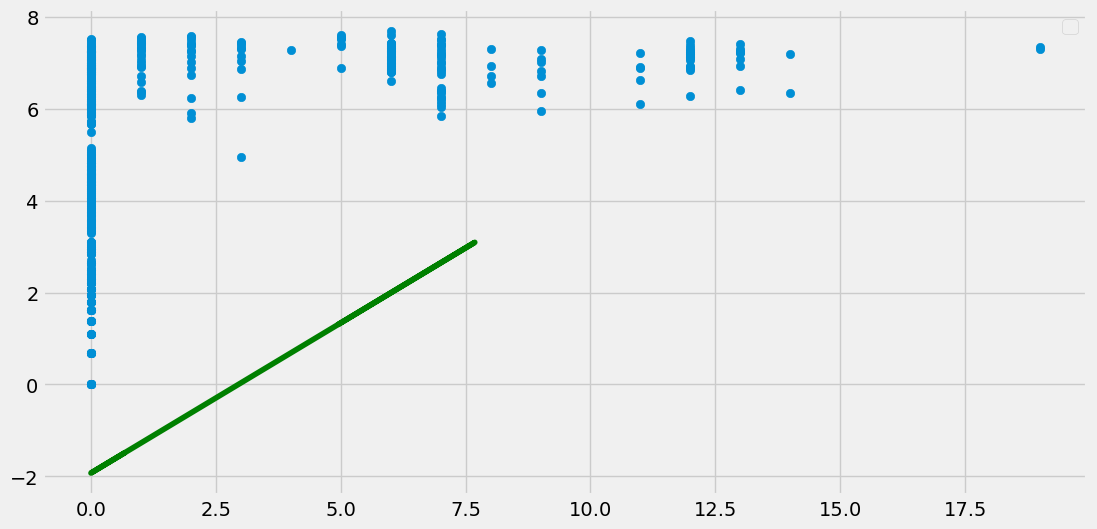

In [40]:
plt.figure(figsize=(12,6))
plt.scatter(Y, X)
plt.plot(X, Y_pred, color='green')
plt.legend()
plt.show()

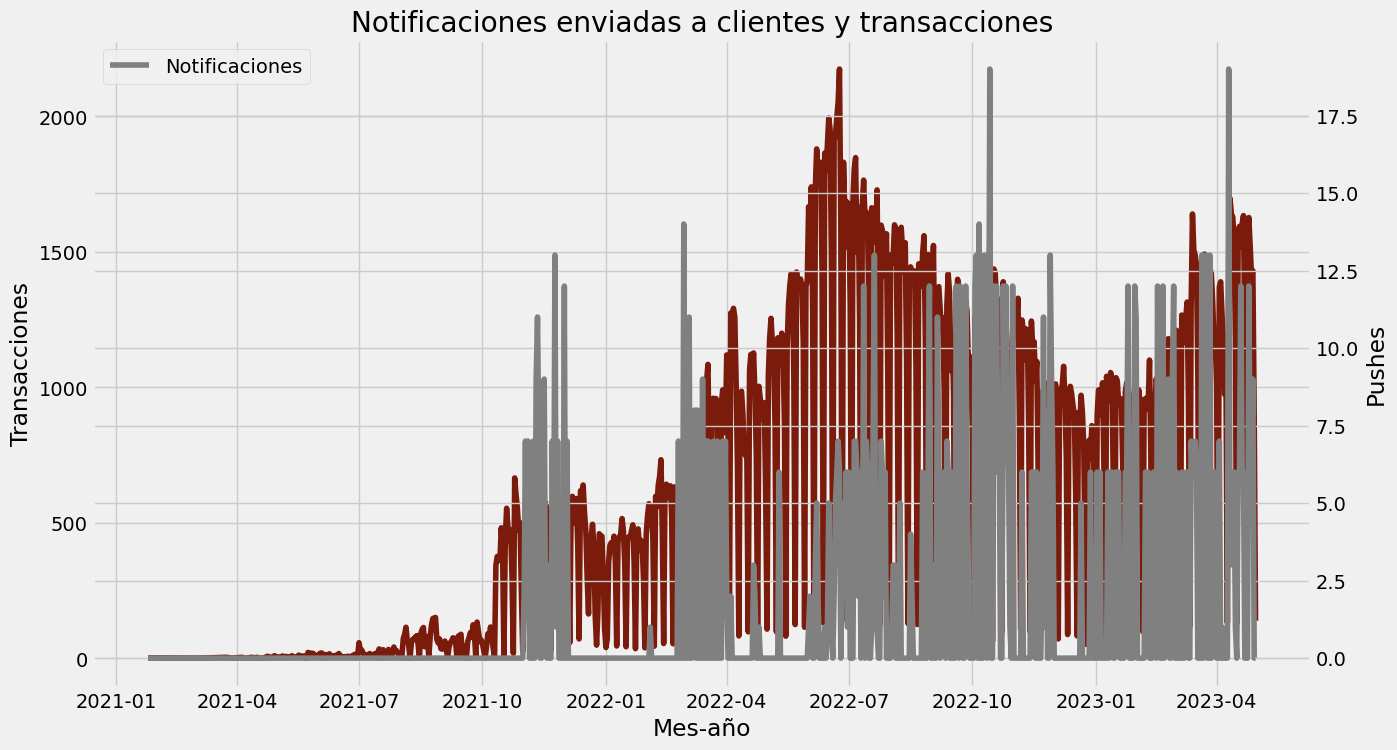

In [45]:
fig, ax = plt.subplots(figsize=(14,8))
ax2 = ax.twinx()
ax.set_title('Notificaciones enviadas a clientes y transacciones')
ax.set_xlabel('Mes-año')
ax.set_ylabel('Transacciones')
ax.plot(pd_merged['fecha'], pd_merged['Pedidos'], color='#7a1b0c', label='new')
ax2.plot(pd_merged['fecha'], pd_merged['Notificaciones'], color='gray', label='Notificaciones')
ax2.set_ylabel('Pushes')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


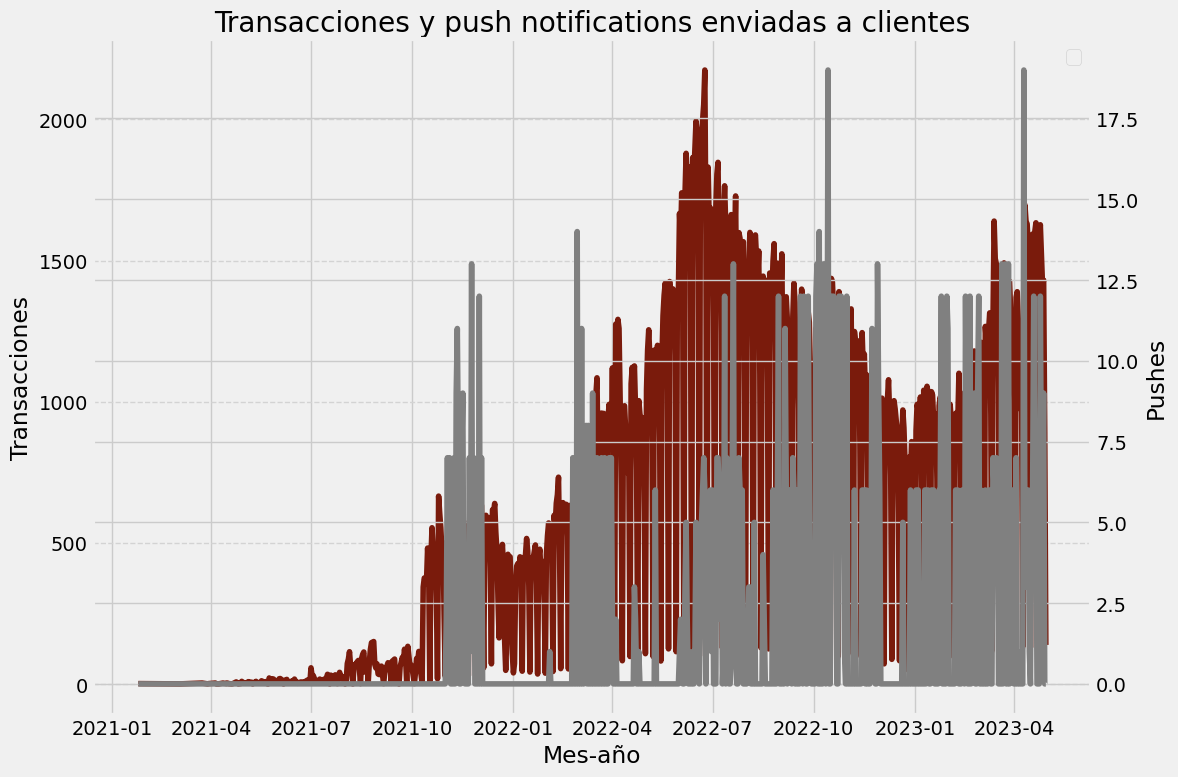

In [46]:
fig, ax = plt.subplots(figsize=(12,8))
ax2 = ax.twinx()
ax.set_title('Transacciones y push notifications enviadas a clientes')
ax.set_xlabel('Mes-año')
ax.set_ylabel('Transacciones')
ax.plot(pd_merged['fecha'], pd_merged['Pedidos'], color='#7a1b0c',)
ax.yaxis.grid(color='lightgray', linestyle='dashed')
ax2.plot(pd_merged['fecha'], pd_merged['Notificaciones'], color='#808080',)
ax2.set_ylabel('Pushes')
plt.tight_layout()
plt.legend()
plt.show()

## Contact

<!-- Avatar -->
<img src="../Pictures/profile2.png" alt="me" width="75" height="80">
<!-- Text with color, font, fontsize and specific size -->
<p style="color:#323232; font-family: Helevetica; font-size: 20px;">Jesus L. Monroy<br>Economist | Data Scientist</p>
<!-- Insert url links in logos -->
<!-- style="padding-left:8px" adds spaces before logo link -->
<!-- Telegram -->
<a href="https://t.me/j3suslm" target="_blank" rel="noreferrer"> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ef/Telegram_X_2019_Logo.svg/2048px-Telegram_X_2019_Logo.png?size=16&color=3b3b3b" alt="telegram" width="30" height="22" style="padding-left:8px"/>
<!-- Twitter -->
<a href="https://www.twitter.com/sqlalchemist" target="_blank" rel="noreferrer"> <img src="https://toppng.com/public/uploads/preview/twitter-x-new-logo-round-icon-png-11692480241tdbz6jparr.webp?size=16&color=3b3b3b" alt="twitter" width="30" height="22" style="padding-left:8px"/>
<!-- Github -->
<a href="https://github.com/SqlAlchemist/My-portfolio" target="_blank" rel="noreferrer"> <img src="https://icongr.am/devicon/github-original.svg?size=16&color=3b3b3b" alt="github" width="30" height="30" style="padding-left:8px"/>
<!-- Linkedin -->
<a href="https://www.linkedin.com/in/j3sus-lmonroy" target="_blank" rel="noreferrer"> <img src="https://icongr.am/simple/linkedin.svg?size=16&color=3b3b3b" alt="linkedin" width="30" height="30" style="padding-left:8px"/>
<!-- Medium -->
<a href="https://medium.com/@jesus_lmonroy" target="_blank" rel="noreferrer"> <img src="https://cdn1.iconfinder.com/data/icons/social-media-and-logos-12/32/Logo_medium-512.png?size=55&color=3b3b3b" alt="medium" width="30" height="33" style="padding-left:8px"/>